In [17]:
import pandas as pd
import re 

# Gensim for topic modeling
import gensim
from gensim.utils import simple_preprocess
from gensim import matutils, models
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
import scipy.sparse

# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shureenteh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
df = pd.read_csv('Late_reviews_ninjaID copy.csv')

In [27]:
# Convert to list
data = df.values.tolist()
data[:5]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Let's start with 2 topics.
lda_model = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=2, passes=10)
lda_model.print_topics()

[(0,
  '0.036*"long" + 0.036*"ninja" + 0.032*"time" + 0.031*"service" + 0.025*"package" + 0.023*"delivery" + 0.016*"express" + 0.015*"day" + 0.014*"courier" + 0.013*"slow"'),
 (1,
  '0.027*"ninja" + 0.025*"use" + 0.025*"slow" + 0.021*"time" + 0.020*"package" + 0.020*"delivery" + 0.019*"long" + 0.017*"bad" + 0.016*"really" + 0.015*"expedition"')]

In [28]:
# Let's start with 10 topics. This may take a while.
lda_model = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=10, passes=10)
lda_model.print_topics()

[(0,
  '0.042*"slow" + 0.042*"work" + 0.042*"customer" + 0.042*"complain" + 0.002*"time" + 0.002*"tlp" + 0.002*"pickup" + 0.002*"change" + 0.002*"pick" + 0.002*"xpress"'),
 (1,
  '0.048*"time" + 0.042*"delivery" + 0.041*"ninja" + 0.038*"service" + 0.029*"long" + 0.026*"use" + 0.025*"package" + 0.023*"slow" + 0.019*"one" + 0.016*"bad"'),
 (2,
  '0.041*"bad" + 0.031*"service" + 0.021*"late" + 0.021*"expedition" + 0.021*"star" + 0.021*"delivery" + 0.021*"failed" + 0.021*"slow" + 0.021*"want" + 0.021*"longest"'),
 (3,
  '0.038*"long" + 0.037*"ninja" + 0.035*"package" + 0.035*"delivery" + 0.021*"like" + 0.021*"good" + 0.021*"service" + 0.014*"return" + 0.014*"lazada" + 0.014*"use"'),
 (4,
  '0.043*"long" + 0.036*"package" + 0.036*"time" + 0.029*"use" + 0.022*"ninja" + 0.022*"arrived" + 0.022*"good" + 0.022*"day" + 0.015*"delivery" + 0.015*"took"'),
 (5,
  '0.033*"long" + 0.033*"disappointed" + 0.028*"time" + 0.022*"courier" + 0.022*"delivery" + 0.022*"want" + 0.020*"really" + 0.019*"slow" +

In [29]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))


[['lazada', 'seller', 'lost', 'lot', 'ninja', 'delivery', 'service', 'trustworthy', 'long', 'hand', 'package', 'always', 'return', 'reason', 'clear', 'week', 'good', 'finally', 'return', 'good']]


In [30]:
# Prepare stopwords using NLTK
stop_words = stopwords.words('english')

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)


[['lazada', 'seller', 'lost', 'lot', 'ninja', 'delivery', 'service', 'trustworthy', 'long', 'hand', 'package', 'always', 'return', 'reason', 'clear', 'week', 'good', 'finally', 'return', 'good']]


In [31]:
# Build the bigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

print(data_words_bigrams[10])

['first', 'time', 'used', 'ninja', 'really', 'disappointed', 'wouldnt', 'use', 'another', 'delivery', 'service', 'longest', 'one', 'week', 'jakarta']


In [32]:
def lemmatization(texts, allowed_postags=['NOUN']):
    """"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component
# For normal use
# !python -m spacy download en_core_web_sm
# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# For Colab use
import en_core_web_sm
nlp = en_core_web_sm.load()

print("Before Lemmatization:", data_words_bigrams[:1])

# Do lemmatization keeping only noun
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'PROPN'])

print("After Lemmatization: ", data_lemmatized[:1])

Before Lemmatization: [['lazada', 'seller', 'lost', 'lot', 'ninja', 'delivery', 'service', 'trustworthy', 'long', 'hand', 'package', 'always', 'return', 'reason', 'clear', 'week', 'good', 'finally', 'return', 'good']]
After Lemmatization:  [['lazada', 'seller', 'lot', 'delivery', 'service', 'hand', 'package', 'reason', 'week', 'good']]


In [33]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
id2word.filter_extremes(no_below=1.5, no_above=0.8) # this will filter out words that are less frequen

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]]


In [34]:
# Build LDA model

# Let's start with 2 topics.
lda_model = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=2, passes=10)
lda_model.print_topics()

[(0,
  '0.078*"time" + 0.067*"service" + 0.058*"delivery" + 0.048*"package" + 0.040*"expedition" + 0.032*"courier" + 0.029*"day" + 0.022*"use" + 0.017*"week" + 0.015*"even_though"'),
 (1,
  '0.053*"package" + 0.027*"courier" + 0.024*"delivery" + 0.024*"name" + 0.020*"ninja" + 0.019*"work" + 0.017*"time" + 0.015*"kaga" + 0.015*"july" + 0.015*"day"')]

In [35]:
# 3 topics.
lda_model = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=3, passes=10)
lda_model.print_topics()

[(0,
  '0.104*"time" + 0.081*"delivery" + 0.045*"expedition" + 0.038*"package" + 0.030*"use" + 0.027*"service" + 0.025*"courier" + 0.021*"ninja" + 0.020*"day" + 0.019*"even_though"'),
 (1,
  '0.045*"time" + 0.041*"service" + 0.034*"courier" + 0.030*"jakarta" + 0.027*"delivery" + 0.026*"day" + 0.026*"transit" + 0.025*"package" + 0.021*"star" + 0.021*"status"'),
 (2,
  '0.093*"package" + 0.075*"service" + 0.034*"courier" + 0.029*"stuff" + 0.029*"day" + 0.028*"week" + 0.018*"lot" + 0.018*"july" + 0.018*"delivery" + 0.016*"ninja"')]

In [36]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.0204217508661095

Coherence Score:  0.5139303730406127


In [37]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []  
    for num_topics in range(start, limit, step):
        print(f'Training model for num_topics= {num_topics}')
        model = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, passes=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [38]:
start = 2
limit = 60
step = 6
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start, limit=limit, step=step)
print('Completed!')

Training model for num_topics= 2
Training model for num_topics= 8
Training model for num_topics= 14
Training model for num_topics= 20
Training model for num_topics= 26
Training model for num_topics= 32
Training model for num_topics= 38
Training model for num_topics= 44
Training model for num_topics= 50
Training model for num_topics= 56
Completed!


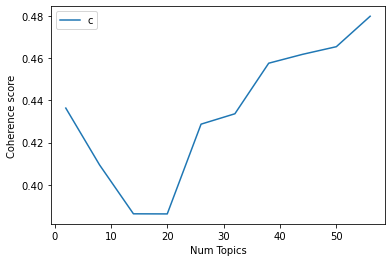

In [39]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [40]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4363
Num Topics = 8  has Coherence Value of 0.4094
Num Topics = 14  has Coherence Value of 0.3863
Num Topics = 20  has Coherence Value of 0.3863
Num Topics = 26  has Coherence Value of 0.4287
Num Topics = 32  has Coherence Value of 0.4336
Num Topics = 38  has Coherence Value of 0.4575
Num Topics = 44  has Coherence Value of 0.4617
Num Topics = 50  has Coherence Value of 0.4653
Num Topics = 56  has Coherence Value of 0.4797


In [41]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/Users/shureenteh/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.042873 -0.126898       1        1  40.757043
1     -0.094389  0.098678       2        1  31.025917
2      0.137262  0.028220       3        1  28.217040, topic_info=          Term       Freq      Total Category  logprob  loglift
23        time  60.000000  60.000000  Default  30.0000  30.0000
5      package  52.000000  52.000000  Default  29.0000  29.0000
132    transit   9.000000   9.000000  Default  28.0000  28.0000
39       stuff  10.000000  10.000000  Default  27.0000  27.0000
8      service  47.000000  47.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
97   complaint   1.975006   5.818562   Topic3  -5.0164   0.1848
45          jt   1.956588   4.165295   Topic3  -5.0258   0.5097
106      check   1.955753   4.165238   Topic3  -5.0262   0.5092
144     regret   1.952433   4.165296   Topic3  -5.0279   0.5075
95      report   1.947649   4.165310   Topic3  -5.0304   0.5051

[179 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
133       2  0.804931           aaaaa
183       1  0.800073  accountability
80        1  0.267670         address
80        2  0.535341         address
80        3  0.267670         address
...     ...       ...             ...
56        1  0.219173          xpress
56        2  0.547931          xpress
56        3  0.219173          xpress
101       2  0.804931            year
57        2  0.863309       yesterday

[183 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

In [42]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['dominant_topic', 'topic_perc_contrib', 'keywords']
    
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus)
df_topic_sents_keywords.head()



,dominant_topic,topic_perc_contrib,keywords
0,2.0,0.9340,"package, service, courier, stuff, day, week, l..."
1,1.0,0.9333,"time, service, courier, jakarta, delivery, day..."
2,0.0,0.7719,"time, delivery, expedition, package, use, serv..."
3,0.0,0.9010,"time, delivery, expedition, package, use, serv..."
4,0.0,0.8288,"time, delivery, expedition, package, use, serv..."


In [24]:

# data = df['Late reviews']
# vectorizer = TfidfVectorizer()
# tdf = vectorizer.fit_transform(data)



In [25]:
# import nltk
# import re

# stop_list = nltk.corpus.stopwords.words('english')
# # The following list is to further remove some frequent words in SGNews.
# # stop_list += ['would', 'said', 'say', 'year', 'day', 'also', 'first', 'last', 'one', 'two', 'people', 'told', 'new', 'could', 'singapore', 'three', 'may', 'like', 'world', 'since']

# import gensim

# def load_corpus(dir):
#     # dir is a directory with plain text files to load.
#     corpus = nltk.corpus.PlaintextCorpusReader(dir, '.+\.txt')
#     return corpus

# def corpus2docs(corpus):
#     # corpus is a object returned by load_corpus that represents a corpus.
#     fids = corpus.fileids()
#     docs1 = []
#     for fid in fids:
#         doc_raw = corpus.raw(fid)
#         doc = nltk.word_tokenize(doc_raw)
#         docs1.append(doc)
#     docs2 = [[w.lower() for w in doc] for doc in docs1]
#     docs3 = [[w for w in doc if re.search('^[a-z]+$', w)] for doc in docs2]
#     docs4 = [[w for w in doc if w not in stop_list] for doc in docs3]
#     return docs4

# def docs2vecs(docs, dictionary):
#     # docs is a list of documents returned by corpus2docs.
#     # dictionary is a gensim.corpora.Dictionary object.
#     vecs1 = [dictionary.doc2bow(doc) for doc in docs]
#     return vecs1

    